<a href="https://colab.research.google.com/github/nuhash-cell/get_csv_from_line_chart/blob/main/Get_csv_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Screenshot 2024-11-19 154232.png to Screenshot 2024-11-19 154232 (5).png
Enter start date (YYYY-MM-DD): 2024-01-01
Enter end date (YYYY-MM-DD): 2024-01-10
Uploaded file: Screenshot 2024-11-19 154232 (5).png


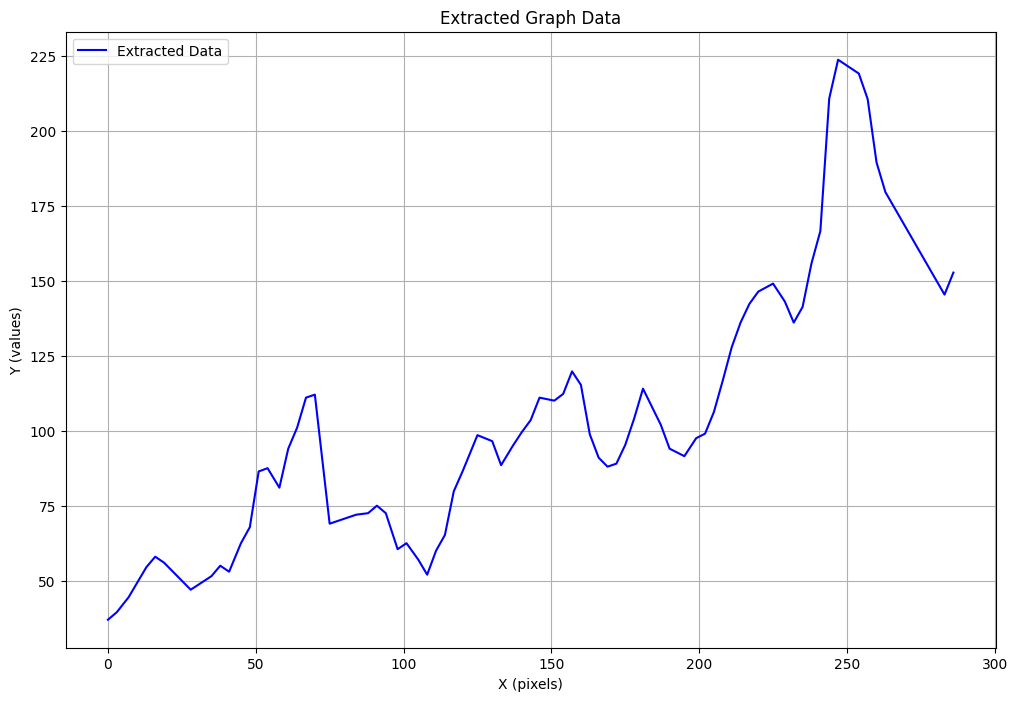

Data saved as 'extracted_data_with_dates.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from datetime import datetime, timedelta

def process_graph():
    # Step 1: Upload the image
    uploaded = files.upload()

    if uploaded:
        # Get date range from user
        while True:
            try:
                start_date_str = input("Enter start date (YYYY-MM-DD): ")
                end_date_str = input("Enter end date (YYYY-MM-DD): ")

                start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
                end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

                if start_date >= end_date:
                    print("Start date must be before end date. Please try again.")
                    continue
                break
            except ValueError:
                print("Invalid date format. Please use YYYY-MM-DD format.")

        file_name = next(iter(uploaded.keys()))
        print(f"Uploaded file: {file_name}")

        # Load the image
        image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)

        # Step 2: Preprocess the image
        # Contrast adjustment
        adjusted = cv2.convertScaleAbs(image, alpha=2.0, beta=0)

        # Apply adaptive thresholding
        binary_image = cv2.adaptiveThreshold(adjusted, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                             cv2.THRESH_BINARY_INV, 11, 2)

        # Dilation to thicken graph lines
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        dilated_image = cv2.dilate(binary_image, kernel, iterations=1)

        # Edge detection with lowered thresholds
        edges = cv2.Canny(dilated_image, 30, 100)

        # Step 3: Extract contours
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Extract data points
        data_points = []
        for contour in contours:
            if cv2.contourArea(contour) > 10:  # Reduced area threshold
                for point in contour:
                    x, y = point[0]
                    data_points.append((x, y))

        if not data_points:
            print("No valid data points found! Check the preprocessing steps.")
            return

        # Flip the Y-axis and sort by X
        height, _ = image.shape
        flipped_data_points = [(x, height - y) for x, y in data_points]
        flipped_data_points = sorted(flipped_data_points, key=lambda p: p[0])

        # Convert to DataFrame
        df = pd.DataFrame(flipped_data_points, columns=["X", "Y"])

        # Group by X and average Y
        df = df.groupby("X", as_index=False).mean()

        # Apply fixed smoothing step of 3
        smoothed_df = df.iloc[::3].copy()  # Create a copy to avoid SettingWithCopyWarning

        # Generate dates for each data point
        total_points = len(smoothed_df)
        date_range = (end_date - start_date).days

        # Create list of evenly spaced dates
        dates = [start_date + timedelta(days=i * (date_range / (total_points - 1)))
                for i in range(total_points)]

        # Add dates to the DataFrame
        smoothed_df['Date'] = dates

        # Reorder columns to have Date first
        smoothed_df = smoothed_df[['Date', 'X', 'Y']]

        # Plot the extracted data
        plt.figure(figsize=(12, 8))
        plt.plot(smoothed_df["X"], smoothed_df["Y"],
                 label="Extracted Data",
                 color="blue",
                 linewidth=1.5)

        plt.title("Extracted Graph Data")
        plt.xlabel("X (pixels)")
        plt.ylabel("Y (values)")
        plt.grid(True)
        plt.legend()
        plt.show()

        # Save the extracted data to a CSV file
        smoothed_df['Date'] = smoothed_df['Date'].dt.strftime('%Y-%m-%d')  # Format dates for CSV
        smoothed_df.to_csv("extracted_data_with_dates.csv", index=False)
        print("Data saved as 'extracted_data_with_dates.csv'")
        files.download("extracted_data_with_dates.csv")

# Run the processing
process_graph()
